In [18]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from functools import reduce
import time

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [19]:
# %%
import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


# --- Logit transformation function ---
def logit(p: pd.Series) -> pd.Series:
    """Converts PSI (0-1) to logit."""
    # Clip for numerical stability to avoid log(0) or log(1)
    p = p.clip(1e-6, 1.0 - 1e-6)
    return np.log(p / (1 - p))

# --- REVISED: Calculates delta-logit from wide PSI DataFrames ---
def get_delta_psi_logit(df: pd.DataFrame, tissue_cols: list, gt_df_full: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Calculates delta-logit for a given wide DataFrame 'df' (predictions or GT)
    by aligning with the logit_mean_psi from the full ground truth 'gt_df_full'.
    Handles potential column name conflicts during merge.
    """
    # Ensure exon_id is present
    if 'exon_id' not in df.columns:
        raise ValueError("Input DataFrame 'df' must contain 'exon_id' column.")
    if 'exon_id' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'exon_id' column.")
    if 'logit_mean_psi' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'logit_mean_psi' column.")

    # Select only the necessary columns from ground truth for the merge
    gt_subset_for_merge = gt_df_full[['exon_id', 'logit_mean_psi']].copy()

    # Define potential suffixes
    suffix_original = '_original_df'
    suffix_from_gt = '_from_gt_df'

    # Perform the merge
    merged_df = pd.merge(
        df,
        gt_subset_for_merge,
        on='exon_id',
        how='left',
        suffixes=(suffix_original, suffix_from_gt)
    )

    # --- Determine the correct ground truth logit_mean_psi column name ---
    gt_logit_mean_col = 'logit_mean_psi'
    if f'logit_mean_psi{suffix_from_gt}' in merged_df.columns:
        gt_logit_mean_col = f'logit_mean_psi{suffix_from_gt}'
    elif 'logit_mean_psi' not in merged_df.columns:
        raise KeyError("Could not find the 'logit_mean_psi' column after merging.")

    # Handle cases where predictions are for exons not in gt_df
    if merged_df[gt_logit_mean_col].isnull().any():
        missing_count = merged_df[gt_logit_mean_col].isnull().sum()
        print(f"Warning: Found {missing_count} exons in input 'df' not found in ground truth. They will be dropped.")
        merged_df = merged_df.dropna(subset=[gt_logit_mean_col])
        if merged_df.empty:
             raise ValueError("After merging and dropping missing ground truth, the DataFrame is empty.")

    # Convert only the specified tissue columns to numeric
    psi_df = merged_df[tissue_cols].apply(pd.to_numeric, errors='coerce')

    # Detect if PSI values are given as percentages (> 1.5)
    if not psi_df.empty and (psi_df.max(skipna=True).max(skipna=True) > 1.5):
        print("Detected PSI values > 1.5, converting from 0-100 scale.")
        psi_df = psi_df / 100.0
    elif psi_df.empty:
         print("Warning: No valid PSI values found to process after filtering/conversion.")
         empty_delta_logit = pd.DataFrame(columns=['exon_id'] + tissue_cols)
         return empty_delta_logit, tissue_cols


    # Compute logit(PSI) for each tissue
    logit_psi_df = psi_df.apply(logit)

    # Subtract the correctly identified ground truth logit_mean_psi
    delta_logit_df = logit_psi_df.sub(merged_df[gt_logit_mean_col], axis=0)

    # Add the exon_id column back
    delta_logit_df['exon_id'] = merged_df['exon_id']

    # Ensure exon_id is the first column for consistency
    delta_logit_df = delta_logit_df[['exon_id'] + tissue_cols]

    return delta_logit_df, tissue_cols

In [20]:
# %%
# --- Loads and processes the ground truth PSI file ---
def load_ground_truth(filepath: str) -> (pd.DataFrame, list):
    """
    Loads the ground truth PSI CSV file and returns the
    wide DataFrame and the list of tissue columns.
    """
    print(f"Loading and processing Ground Truth from: {filepath}")
    df = pd.read_csv(filepath)
    
    # This column indexing is from your script
    meta_cols = [
        'exon_id', 'cassette_exon', 'alternative_splice_site_group', 'linked_exons',
        'mutually_exclusive_exons', 'exon_strand', 'exon_length', 'gene_type',
        'gene_id', 'gene_symbol', 'exon_location', 'exon_boundary',
        'chromosome', 'mean_psi', 'logit_mean_psi', 'chromosome.1'
    ]
    tissue_cols = [col for col in df.columns if col not in meta_cols]
    
    # --- NEW: Ensure PSI values are 0-1 ---
    # Check if max PSI is > 1.5, indicating 0-100 scale
    if not df[tissue_cols].empty and (df[tissue_cols].max(skipna=True).max(skipna=True) > 1.5):
        print("Ground Truth: Detected PSI values > 1.5, converting from 0-100 scale.")
        df[tissue_cols] = df[tissue_cols] / 100.0
    
    return df, list(tissue_cols)


# --- MODIFIED: Loads single run *PSI predictions* ---
def load_single_run_predictions(results_folder: str, run_name: str=None) -> (pd.DataFrame, list):
    """
    Loads the raw PSI predictions for a single run
    and returns a wide DataFrame and the list of tissue columns.
    """
    if run_name is None:
        filepath = Path(results_folder) / 'tsplice_final_predictions_all_tissues.tsv'
    else:
        filepath = Path(results_folder) / run_name / 'tsplice_final_predictions_all_tissues.tsv'
    if not filepath.exists():
        raise FileNotFoundError(f"Prediction file not found at: {filepath}")
        
    print(f"Loading single run PSI predictions from: {filepath}")
    
    df = pd.read_csv(filepath, sep='\t')
    
    # This column indexing is from your script
    pred_cols = df.columns[1:]
    
    # --- NEW: Ensure PSI values are 0-1 ---
    if not df[pred_cols].empty and (df[pred_cols].max(skipna=True).max(skipna=True) > 1.5):
        print(f"Predictions ({run_name}): Detected PSI values > 1.5, converting from 0-100 scale.")
        df[pred_cols] = df[pred_cols] / 100.0
    
    return df, list(pred_cols)

In [21]:
import numpy as np
from scipy.stats import spearmanr, linregress

def calculate_metrics_by_tissue(
    pred_df: pd.DataFrame,
    gt_df: pd.DataFrame,
    gt_col: str,
    pred_col: str,
    base_name: str
) -> pd.DataFrame:
    """
    Computes RMSE, Spearman correlation, and slope between GT and prediction
    for each tissue.
    """
    merged_df = pd.merge(gt_df, pred_df, on=["exon_id", "tissue"]).dropna(subset=[gt_col, pred_col])

    if merged_df.empty:
        print(f"⚠️ Warning: No overlapping data found for {gt_col} vs {pred_col}")
        return pd.DataFrame(columns=["tissue", f"rmse_{base_name}", f"spearman_{base_name}", f"slope_{base_name}"])

    results = []
    for tissue, grp in merged_df.groupby("tissue"):
        y_true, y_pred = grp[gt_col].values, grp[pred_col].values
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        rho, _ = spearmanr(y_true, y_pred)
        slope, _, _, _, _ = linregress(y_true, y_pred)
        results.append({
            "tissue": tissue,
            f"rmse_{base_name}": rmse,
            f"spearman_{base_name}": rho,
            f"slope_{base_name}": slope
        })
    
    return pd.DataFrame(results)


In [22]:
def process_user_run(folder_path: str, model_name: str, gt_df_full: pd.DataFrame, gt_cols: list, run_name: str=None) -> dict:
    """
    Loads a user run, computes PSI, ΔPSI, and Δlogit(Ψ) metrics.
    Returns a dictionary with detailed results.
    """
    print(f"\n--- Processing Model: {model_name} ---")
    
    pred_psi_df, pred_tissueCols = load_single_run_predictions(folder_path, run_name)
    
    # Long-format PSI
    pred_psi_long = pred_psi_df.melt(
        id_vars=["exon_id"],
        value_vars=pred_tissueCols,
        var_name="tissue",
        value_name="pred_psi"
    )
    
    # Compute RMSE + correlation + slope
    psi_metrics = calculate_metrics_by_tissue(
        pred_psi_long, gt_psi_long, "gt_psi", "pred_psi", "psi"
    )
    
    return {
        "model_name": model_name,
        "pred_psi_long": pred_psi_long,
        "psi_metrics": psi_metrics
    }


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_psi_scatter(pred_df, gt_df, tissue_name, model_name, save_path=None):
    """
    Plots PSI_true vs PSI_pred for a given tissue, with correlation and slope annotation.
    """
    merged = pd.merge(gt_df, pred_df, on=["exon_id", "tissue"]).dropna(subset=["gt_psi", "pred_psi"])
    merged = merged[merged["tissue"] == tissue_name]

    if merged.empty:
        print(f"⚠️ No data found for tissue: {tissue_name}")
        return

    # Compute Spearman and slope
    rho, _ = spearmanr(merged["gt_psi"], merged["pred_psi"])
    slope, intercept, _, _, _ = linregress(merged["gt_psi"], merged["pred_psi"])

    # Plot
    plt.figure(figsize=(5, 5))
    sns.regplot(x="gt_psi", y="pred_psi", data=merged, scatter_kws={"s": 20, "alpha": 0.7}, line_kws={"color": "red"})
    plt.xlabel("Ground Truth PSI", fontsize=12, weight="bold")
    plt.ylabel(f"{model_name} Predicted PSI", fontsize=12, weight="bold")
    plt.title(f"{tissue_name}\nρ={rho:.2f}, slope={slope:.2f}", fontsize=13, weight="bold")
    plt.grid(alpha=0.3)
    
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
    #     print(f"✅ Saved scatter: {save_path}")
    plt.show()


In [ ]:
# # --- Cell types to visualize ---


# # --- Directory setup ---
# # main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"
# # os.makedirs(main_dir, exist_ok=True)


# def plot_psi_scatter(pred_df, gt_df, tissue_name, model_name, save_dir):
#     """
#     PSI_true vs PSI_pred for a given tissue, annotated with Spearman rho and slope.
#     """
#     merged = pd.merge(gt_df, pred_df, on=["exon_id", "tissue"]).dropna(subset=["gt_psi", "pred_psi"])
#     merged = merged[merged["tissue"] == tissue_name]

#     if merged.empty:
#         print(f"⚠️ No data found for tissue: {tissue_name}")
#         return

#     # Compute Spearman correlation and slope
#     rho, _ = spearmanr(merged["gt_psi"], merged["pred_psi"])
#     slope, intercept, _, _, _ = linregress(merged["gt_psi"], merged["pred_psi"])

#     # Plot
#     plt.figure(figsize=(5, 5))
#     sns.regplot(
#         x="gt_psi",
#         y="pred_psi",
#         data=merged,
#         scatter_kws={"s": 20, "alpha": 0.7},
#         line_kws={"color": "red", "lw": 1.2},
#     )
#     plt.xlabel("Ground Truth PSI", fontsize=12, weight="bold")
#     plt.ylabel(f"{model_name} Predicted PSI", fontsize=12, weight="bold")
#     plt.title(f"{tissue_name}\nρ={rho:.2f}, slope={slope:.2f}", fontsize=13, weight="bold")
#     plt.grid(alpha=0.3)

#     # Save
#     fname_safe = tissue_name.replace(" ", "_").replace(",", "").replace("+", "plus")
#     save_path = f"{save_dir}/scatter_PSI_{fname_safe}_{model_name}.png"
#     plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
#     plt.close()
#     print(f"✅ Saved: {save_path}")

In [24]:
# %%
# --- 1. Define ALL file paths ---
NYGC = 1
division = 'variable'
# metric_name = 'rmse_delta_logit' # This is no longer the single metric

# SOTA Model
sota_model_name = 'MTSplice_original_Sota'

# --- Folder 1 (Define paths and names for your second experiment) ---
result_file_name1 = "exprmnt_2025_11_01__12_32_21" # EMPRAIPsi_300bp_MTCLSwept_10Aug_noExonPad_2025_11_01__12_32_21
model1_user_name_norun = '300bp_MTCLSwept_10Aug_noExonPad'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_01__12_32_21" # EMPRAIPsi_300bp_MTCLSwept_10Aug_noExonPad_2025_11_01__12_32_21
model2_user_name_norun = '300bp_MTCLSwept_10Aug_noExonPad_ignore'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None


# Experiment 1
exp1_name = result_file_name1 # newMTmodel_300bp intron
model1_user_name_norun = model1_user_name_norun
exp1_run_name = model1_runNumber
model1_name = model1_user_name

# Experiment 2
exp2_name = result_file_name2
model2_user_name_norun = model2_user_name_norun
exp2_run_name = model2_runNumber
model2_name = model2_user_name

In [25]:
# %%
# --- Setup base paths ---
if NYGC == 1:
    main_dir = '/gpfs/commons/home/atalukder/'
else:
    main_dir = "/mnt/home/at3836/"

import time
    
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Ground Truth File Path ---
GT_FILE_PATH = f"{main_dir}/Contrastive_Learning/data/final_data/ASCOT_finetuning/{division}_cassette_exons_with_logit_mean_psi.csv"

# --- SOTA Predictions File Path ---
# SOTA_PREDS_PATH = f"{main_dir}Contrastive_Learning/files/results/mtsplice_originalTFweight_results/intron_300bp_results/{division}_all_tissues_predicted_logit_delta.tsv"

# --- Experiment Folder Paths ---
EXP1_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp1_name}/ensemble_evaluation_from_valdiation/test_set_evaluation"
EXP2_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp2_name}/ensemble_evaluation_from_valdiation/test_set_evaluation"

# EXP3_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp3_name}/weights/checkpoints"

print(f"Figure save directory set to: {fig_maindir}")
print(f"Timestamp for files: {trimester}")

Figure save directory set to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures
Timestamp for files: _2025_11_09__19_40_40


In [26]:
# %%
# --- 2. Load Ground Truth (Load ONCE) ---
print("--- Loading Ground Truth ---")
try:
    gt_df, gt_tissueCols = load_ground_truth(GT_FILE_PATH)
    
    # --- Create long-format GT for all 3 metrics ---
    
    # 1. PSI
    gt_psi_long = gt_df[['exon_id'] + gt_tissueCols].melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_psi'
    )
    
    # 2. Delta PSI (ΔΨ)
    # Calculate wide-format delta-psi
    delta_psi_df = gt_df[gt_tissueCols].sub(gt_df['mean_psi']/100, axis=0)
    delta_psi_df['exon_id'] = gt_df['exon_id']
    gt_delta_psi_long = delta_psi_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_psi'
    )

    # 3. Delta Logit PSI (Δlogit(Ψ))
    gt_delta_logit_df, _ = get_delta_psi_logit(gt_df, gt_tissueCols, gt_df)
    gt_delta_logit_long = gt_delta_logit_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_logit'
    )
    
    print("Ground Truth processing complete for PSI, ΔPSI, and Δlogit(Ψ).")
    
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find ground truth file at {GT_FILE_PATH}")
    raise
except Exception as e:
    print(f"FATAL ERROR processing ground truth: {e}")
    raise

--- Loading Ground Truth ---
Loading and processing Ground Truth from: /gpfs/commons/home/atalukder//Contrastive_Learning/data/final_data/ASCOT_finetuning/variable_cassette_exons_with_logit_mean_psi.csv
Ground Truth: Detected PSI values > 1.5, converting from 0-100 scale.
Ground Truth processing complete for PSI, ΔPSI, and Δlogit(Ψ).



--- Processing Model: CLADE ---
Loading single run PSI predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_01__12_32_21/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
Predictions (None): Detected PSI values > 1.5, converting from 0-100 scale.


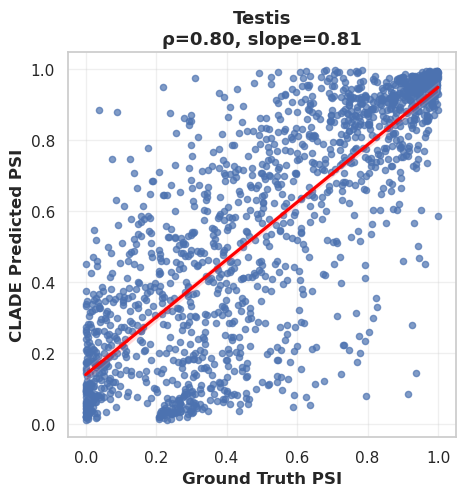

In [27]:
# After process_user_run()
# baseline_results = process_user_run(BASELINE_PATH, "Baseline", gt_df, gt_tissueCols, run_name="run_1")
clade_results    = process_user_run(EXP2_FOLDER_PATH, "CLADE", gt_df, gt_tissueCols, run_name=model2_runNumber)

# Plot for “basal cell”
# plot_psi_scatter(
#     pred_df=baseline_results["pred_psi_long"],
#     gt_df=gt_psi_long,
#     tissue_name="basal cell",
#     model_name="Baseline",
#     save_path="/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/scatter_basalcell_baseline.png"
# )

plot_psi_scatter(
    pred_df=clade_results["pred_psi_long"],
    gt_df=gt_psi_long,
    tissue_name="Testis",
    model_name="CLADE",
    save_path="/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/scatter_basalcell_clade.png"
)


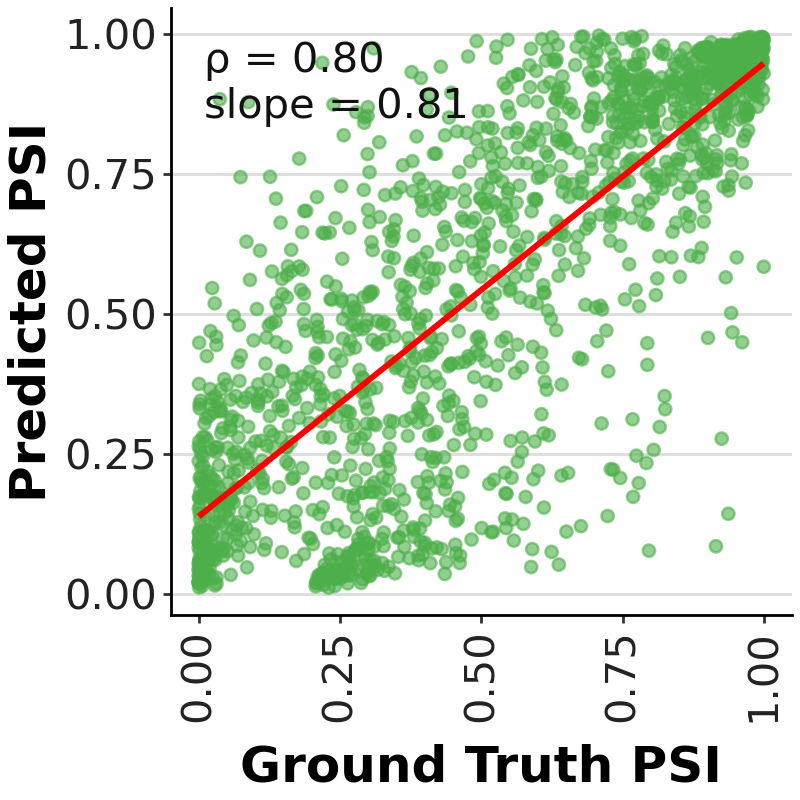

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testis_SOTA_vs_CLADE_20251109_194114.eps
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testis_SOTA_vs_CLADE_20251109_194114.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testis_SOTA_vs_CLADE_20251109_194114.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testis_SOTA_vs_CLADE_20251109_194114.pdf


In [29]:
from plotnine import (
    ggplot, aes, geom_point, geom_smooth, labs, theme_bw, theme,
    element_text, element_blank, annotate
)
from scipy.stats import spearmanr, linregress


def plot_psi_scatter_plotnine(pred_df, gt_df, tissue_name, model_name, save_path=None):
    merged = pd.merge(gt_df, pred_df, on=["exon_id", "tissue"]).dropna(subset=["gt_psi", "pred_psi"])
    merged = merged[merged["tissue"] == tissue_name]

    if merged.empty:
        print(f"⚠️ No data found for tissue: {tissue_name}")
        return

    # --- Compute Spearman and slope ---
    rho, _ = spearmanr(merged["gt_psi"], merged["pred_psi"])
    slope, intercept, _, _, _ = linregress(merged["gt_psi"], merged["pred_psi"])

    # --- Plot ---
    p = (
        ggplot(merged, aes(x="gt_psi", y="pred_psi"))
        + geom_point(alpha=0.6, size=2, color="#4daf4a")  # green points
        + geom_smooth(method="lm", color="red", se=False, size=1.2)
        + annotate(
            "text",
            x=merged["gt_psi"].min() + 0.01,   # position slightly right of left border
            y=merged["pred_psi"].max() - 0.01, # position slightly below top
            label=f"ρ = {rho:.2f}\nslope = {slope:.2f}",
            ha="left", va="top",
            size=15, color="#111111"
        )
        + labs(
            x="Ground Truth PSI",
            y=f"Predicted PSI",
            # title=f"{tissue_name}"
        )
        + theme_bw()
        + theme(
            figure_size=(4, 4),
            axis_text_x=element_text(
                size=15, angle=90, ha="center", va="top", color="#222222"
            ),
            axis_text_y=element_text(size=15, color="#222222"),
            axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
            axis_title_y=element_text(size=18, weight="bold"),
            plot_title=element_text(size=15, weight="bold", ha="center"),
            panel_border=element_blank(),
            panel_grid_major_y=element_text(color="#dddddd"),
            panel_grid_minor_y=element_blank(),
            panel_grid_major_x=element_blank(),
            panel_grid_minor_x=element_blank(),
            axis_line_x=element_text(color="black"),
            axis_line_y=element_text(color="black"),
        )
    )

    # --- Display in notebook ---
    p.show()
    metric_col = "testis"
    # --- Save ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    out_path = f"{main_dir}/fig_TissueWise_ASCOT_{metric_col}_SOTA_vs_CLADE_{timestamp}"
    fig = p.draw()
    fig.set_size_inches(4, 4)
    def normalize_svg_viewbox(svg_path, target_size=(400, 400)):
        from xml.etree import ElementTree as ET
        tree = ET.parse(svg_path)
        root = tree.getroot()
        root.set("width", f"{target_size[0]}")
        root.set("height", f"{target_size[1]}")
        root.set("viewBox", f"0 0 {target_size[0]} {target_size[1]}")
        tree.write(svg_path)

    for fmt in ["eps", "png", "svg", "pdf"]:
        save_path = f"{out_path}.{fmt}"
        fig.savefig(
            save_path,
            dpi=300,
            facecolor="white",
            bbox_inches="tight", pad_inches=0
        )
        if fmt == "svg":
            normalize_svg_viewbox(save_path)
        print(f"✅ Saved: {save_path}")

    plt.close(fig)

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"


plot_psi_scatter_plotnine(
    pred_df=clade_results["pred_psi_long"],
    gt_df=gt_psi_long,
    tissue_name="Testis",
    model_name="CLADE",
    )

In [ ]:
target_tissues = [
    "basal cell",
    "mesenchymal stem cell",
    "fibroblast",
    "macrophage",
    "type ii pneumocyte",
    "plasma cell",
    "adventitial fibroblast",
    "cd4-positive, alpha-beta t cell",
    "endothelial cell",
    "cd8-positive, alpha-beta t cell",
    "endothelial cell of vascular tree",
    "capillary endothelial cell",
    "stromal cell",
    "memory b cell",
    "mast cell",
    "t cell",
    "basal bladder urothelial cell",
    "pericyte",
    "skeletal muscle satellite stem cell",
    "b cell",
    "cd8-positive, alpha-beta memory t cell",
    "nk cell",
    "innate lymphoid cell",
    "cd34+ fibroblasts",
    "vein endothelial cell",
    "paneth cell of colon",
    "monocyte",
    "cd4-positive, alpha-beta memory t cell",
    "paneth cell of epithelium of small intestine",
]

In [ ]:
# for model_results in [baseline_results, clade_results]:
#     model_name = model_results["model_name"]
#     pred_long = model_results["pred_psi_long"]

#     print(f"\n--- Generating PSI scatter plots for {model_name} ---")
clade_results    = process_user_run(EXP2_FOLDER_PATH, "CLADE", gt_df, gt_tissueCols, run_name=model2_runNumber)

for tissue in target_tissues:
    plot_psi_scatter(
        clade_results["pred_psi_long"],
        gt_psi_long,
        tissue, 
        "CLADE",
        "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/extra/")

print("\n🎉 All scatter plots generated successfully!")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_delta_logit_histogram(gt_logit_long, pred_logit_long, tissue_name, model_name, save_dir=None):
    """
    Plots Δlogit(Ψ)_true vs Δlogit(Ψ)_pred for a given tissue.
    """
    # Merge GT + prediction on exon_id + tissue
    merged = pd.merge(gt_logit_long, pred_logit_long, on=["exon_id", "tissue"], how="inner")
    merged = merged[merged["tissue"] == tissue_name].dropna(subset=["gt_delta_logit", "pred_delta_logit"])
    
    if merged.empty:
        print(f"⚠️ No overlapping Δlogit data for {tissue_name}")
        return

    plt.figure(figsize=(9, 3.5))
    sns.histplot(
        merged["gt_delta_logit"], bins=50, color="skyblue", label="Δlogit_true", kde=False,
        stat="density", alpha=0.5
    )
    sns.histplot(
        merged["pred_delta_logit"], bins=50, color="orange", label="Δlogit_pred", kde=False,
        stat="density", alpha=0.6
    )

    plt.title(f"Histogram of Δlogit in {tissue_name} – {model_name}: true vs predicted", fontsize=11)
    plt.xlabel("Δlogit", fontsize=12, weight="bold")
    plt.ylabel("Density", fontsize=12, weight="bold")
    plt.legend(frameon=False, fontsize=10)
    plt.grid(alpha=0.3)

    if save_dir:
        fname_safe = tissue_name.replace(" ", "_").replace(",", "").replace("+", "plus")
        save_path = f"{save_dir}/hist_Dlogit_{fname_safe}_{model_name}.png"
        plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"✅ Saved: {save_path}")

    plt.show()


In [ ]:
# assuming you already have:
# gt_delta_logit_long = ground truth (long-format)
# pred_delta_logit_long = model predictions (same long-format)
# model_name = "CLADE"
# main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"

plot_delta_logit_histogram(
    gt_logit_long=gt_delta_logit_long,
    pred_logit_long=clade_results["pred_delta_logit_long"],
    tissue_name="basal cell",
    model_name="CLADE",
    save_dir=main_dir
)
